In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import warnings
warnings.filterwarnings("ignore")

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Helper functions and Methods

In [2]:
# Method for quick parsing of data sets, returns a list of touples (values, sample rates)
def lib_read(data_set):
    return [ (values,samplerate) for values,samplerate in [librosa.load(data_set[val]) for val in range(len(data_set))]]

In [3]:
# constructs audio classes and returns a list to group data
def construct( data, title ):
    return [audio_data(val,f'{title}_{num}') for num,val in enumerate(data)]

In [4]:
# quick plotting and parsing
class audio_data:
    def __init__( self, data, title ):
        raw,sample_rate = data
        self.title = title 
        self.raw = raw                                      #raw data from time domain
        self.sample_rate = sample_rate                      #extracted sample rate
        self.total_time = len(raw)/sample_rate #total time duration
        # self.sample_period = 1/sample_rate
        # self.timing = np.arange(0,self.total_time,self.sample_period)
        self.transform = self._transform()                 #contains the FFT of signal
        self.db = self._todb()                             #converts values to dB scale
        self.frame_width = None                            #time duration of acoustic frame
        self.frame_samples = None                          #number of samples in acoustic frame
        self.log_mel_spectrogram = None                    #builds spectrogram 
        self.num_frames = None                            #total number of frames
        self.freq_bins = None                             #total number of frequency bins
        self.frame = None                                 #slice raw data by frame
        self.entry_point()
        
        
        
    def entry_point( self, frame = 1024, spacing = 512,bins = 32 ):
        #method for changing freq resolution, frequency bins, or frequency spacing
        self._gen_mel_spec( frame, spacing, bins )
        
    def info( self ):
        print(f' Temporal acoustic frames: {self.num_frames}')
        print(f' Frame_width = {np.round(self.frame_width*1000 ,3)}ms for each {self.frame_samples} samples')
        print(f' Frequency bins: {self.freq_bins}')
        
    
    def _gen_mel_spec( self, frame,spacing, bins):
        mel_spectrogram = librosa.feature.melspectrogram(self.raw, sr=self.sample_rate, n_fft=frame, hop_length=spacing, n_mels=bins)
        frame_width = self.total_time/mel_spectrogram.shape[1]
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        self.frame_width = frame_width
        self.num_frames = log_mel_spectrogram.shape[1]
        self.freq_bins = log_mel_spectrogram.shape[0]
        self.log_mel_spectrogram = log_mel_spectrogram
        self.frame_samples = int(np.floor(len(self.raw)/self.num_frames))
        self.frame = [self.raw[m*self.frame_samples : (m+1)*self.frame_samples] for m in range(0,int(self.num_frames))]

    def _transform( self ):
        return librosa.stft(self.raw)
    def _todb( self ):
        return librosa.amplitude_to_db(np.abs(self.transform), ref=np.max)
    
    def time_domain( self ):
        pd.Series(self.raw).plot(figsize=(10,5), title=self.title)
        plt.xlabel('Samples')
        plt.show()
        
    def spectrogram( self ):
        fig, ax = plt.subplots(figsize=(10,5))
        img = librosa.display.specshow(self.db,
                              x_axis = 'time',
                              y_axis = 'log',
                              ax=ax)
        ax.set_title(self.title, fontsize = 20)
        fig.colorbar(img, ax=ax, format=f'%0.2f')
        plt.show()
        
    def sbs ( self ):

        pd.Series(self.raw).plot(figsize=(10,5), title=f'Time Domain {self.title}')
        plt.xlabel('Samples')
        plt.show()
        print(f'Total Time of Signal: {np.round(self.total_time,3)}sec')
        self.spectral_lines()
        self.mel_spec()
        
    def spectral_lines( self ):
        plt.plot(self.log_mel_spectrogram.T)
        plt.show()
        
    def mel_spec( self ):
        
        # (signal, samplerate, width of acoustic frame, frequency spacing, number of freq bins )

        plt.figure(figsize=(12, 5))
        librosa.display.specshow(self.log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=self.sample_rate)

        plt.colorbar(format="%+2.f")
        plt.show()
        self.info()

**Import the data**

In [5]:
# four words, Down, Up, Yes, No
down_set = glob('../input/vcdata1/VCData/Down/*.wav')
up_set = glob('../input/vcdata1/VCData//Up/*.wav')
no_set = glob('../input/vcdata1/VCData//No/*.wav')
yes_set = glob('../input/vcdata1/VCData//Yes/*.wav')

# Create the data set from librosa
#### DATA SETS ######
down_data = lib_read(down_set)
up_data = lib_read(up_set)
no_data = lib_read(no_set)
yes_data = lib_read(yes_set)

down = construct(down_data,'Down')
up = construct(up_data,'Up')
no = construct(no_data,'No')
yes = construct(yes_data,'Yes')

**Lets listen to one recording**

In [6]:
ipd.Audio(up_set[0])

**Lets look at the data we've generated on UP_0**

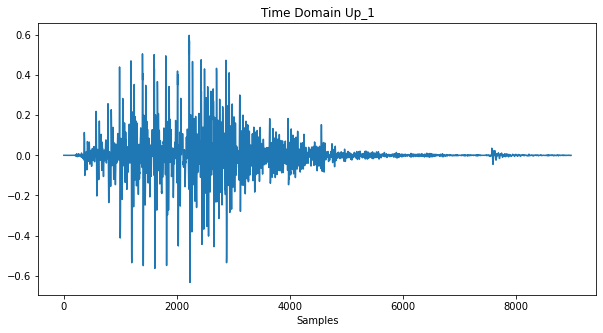

Total Time of Signal: 0.407sec


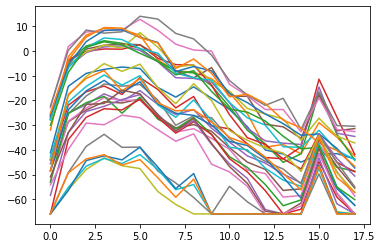

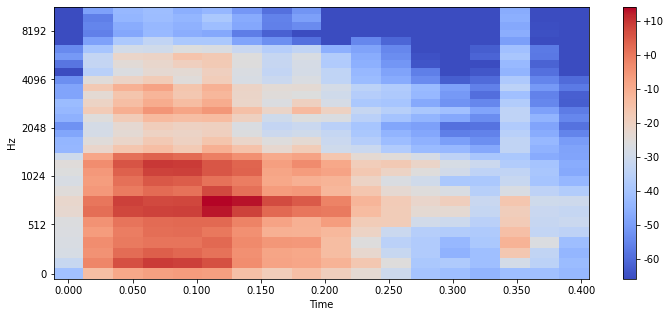

 Temporal acoustic frames: 18
 Frame_width = 22.635ms for each 499 samples
 Frequency bins: 32


In [7]:
#Plot
up[1].sbs()

# Can we separate phonemes?

Need a slicing algo to evaluate short segments  
Then we need features of phonemes (intensity in time domain, intensity in frequencies, bandwidth of frequencies)

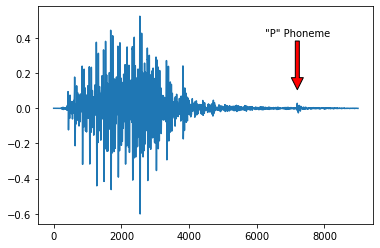

In [8]:
rng = range(0,len(up[0].raw))
plt.plot(rng, up[0].raw)
plt.annotate('"P" Phoneme',
             xy=(7200, 0.1),
             horizontalalignment='center',
             verticalalignment='bottom',
             arrowprops={'facecolor':'red','shrink':0.02},
             xytext = (7200, 0.4)
            )
plt.show()

We can see the 'P' phenom in the time domain

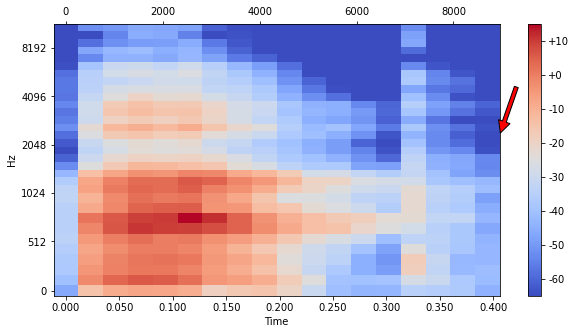

(32, 18)

In [9]:
def group( x ):
    return (x*22050)
def ungroup (x):
    return (x/22050)
fig, ax = plt.subplots(figsize=(10,5))
librosa.display.specshow(up[0].log_mel_spectrogram, 
                 x_axis="time",
                 y_axis="mel", 
                 sr=up[0].sample_rate)

plt.colorbar(format="%+2.f")
plt.annotate('"P" Phoneme',
             xy=(500, 200),
             xycoords='figure points',
             horizontalalignment='center',
             color = 'white',
             verticalalignment='bottom',
             arrowprops={'facecolor':'red','shrink':0.02},
             xytext = (550, 250)
            )
sec_ax = ax.secondary_xaxis('top',functions=(group,ungroup))
plt.show()
np.shape(up[0].log_mel_spectrogram)

We can see the same 'P' phoneme in the frequency domain

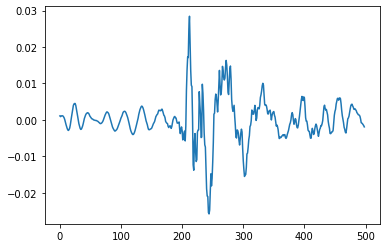

In [10]:
plt.plot(up[0].frame[14])

This frame contains the 'P' phoneme in the time domain

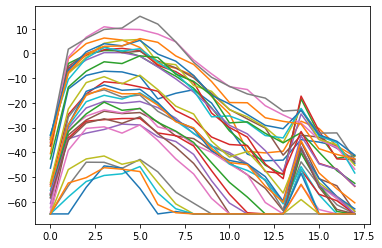

In [11]:
plt.plot(up[0].log_mel_spectrogram.T)
plt.show()

here are the intensities of the frequencies over each frame